100%|██████████| 170M/170M [00:13<00:00, 13.1MB/s]


Epoch [0], val_loss: 1.7726, val_acc: 0.3417
Epoch [1], val_loss: 1.5674, val_acc: 0.4216
Epoch [2], val_loss: 1.4680, val_acc: 0.4629
Epoch [3], val_loss: 1.3172, val_acc: 0.5237
Epoch [4], val_loss: 1.1641, val_acc: 0.5808
Epoch [5], val_loss: 1.1242, val_acc: 0.5937
Epoch [6], val_loss: 0.9810, val_acc: 0.6464
Epoch [7], val_loss: 0.9823, val_acc: 0.6461
Epoch [8], val_loss: 0.9059, val_acc: 0.6818
Epoch [9], val_loss: 0.8659, val_acc: 0.6882
Epoch [10], val_loss: 0.8518, val_acc: 0.6975
Epoch [11], val_loss: 0.7822, val_acc: 0.7239
Epoch [12], val_loss: 0.7678, val_acc: 0.7338
Epoch [13], val_loss: 0.7095, val_acc: 0.7514
Epoch [14], val_loss: 0.6759, val_acc: 0.7622
Epoch [15], val_loss: 0.6402, val_acc: 0.7751
Epoch [16], val_loss: 0.6379, val_acc: 0.7781
Epoch [17], val_loss: 0.5949, val_acc: 0.7966
Epoch [18], val_loss: 0.6199, val_acc: 0.7855
Epoch [19], val_loss: 0.5862, val_acc: 0.7925
Epoch [20], val_loss: 0.5487, val_acc: 0.8163
Epoch [21], val_loss: 0.5439, val_acc: 0.808

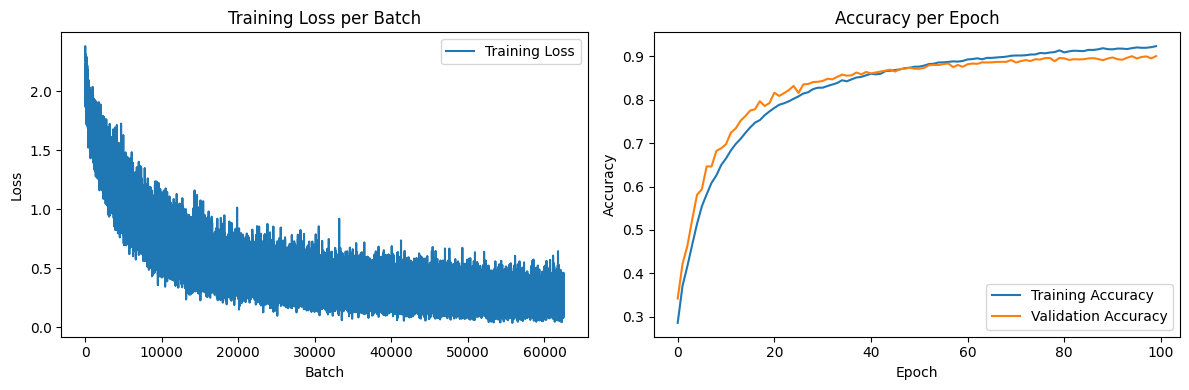

Final Test Results: {'val_loss': 0.24433167278766632, 'val_acc': 0.9224721193313599}
Final Test Accuracy: 0.9225


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils as utils
import torchvision
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.optim as optim
import multiprocessing

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_transform = transforms.Compose([
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor()
])
test_transform = transforms.Compose([transforms.ToTensor()])

# Load data
dataset = CIFAR10(root='./data', train=True, download=True, transform=train_transform)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=test_transform)

# Split training data into training and validation
torch.manual_seed(43)
training_size = len(dataset) - 10000
train_data, val_data = utils.data.random_split(dataset, [training_size, 10000])

batch_size = 64
num_workers = multiprocessing.cpu_count() - 1
train_loader = utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
val_loader = utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
test_loader = utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader:
    def __init__(self, dataloader, device):
        self.dataloader = dataloader
        self.device = device
    def __iter__(self):
        for batch in self.dataloader:
            yield to_device(batch, self.device)
    def __len__(self):
        return len(self.dataloader)

train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

# IntermediateBlock
class IntermediateBlock(nn.Module):
    def __init__(self, in_channels=3, out_channels=32, num_layers=4, dropout=0.2):
        super(IntermediateBlock, self).__init__()
        self.network = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels)
            ) for _ in range(num_layers)
        ])
        self.weights = nn.Linear(in_channels, num_layers)
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout2d(dropout)

    def forward(self, x):
        m = torch.mean(x, dim=(2, 3)) #Global Average pooling m shape (batch size, in channels)
        a = torch.softmax(self.weights(m), dim=1) #Normalisation for weight vector a (batch_size, num_layers)
        outputs = [net(x) for net in self.network] #shape of outputs: (batch_size, num_layers, out_channels, height, width)
        outputs = torch.stack(outputs, dim=1)
        a = a.view(x.size(0), -1, 1, 1, 1)
        out = torch.sum(outputs * a, dim=1) #shape of out: (batch_size, out_channels, height, width)
        out = self.activation(out)
        out = self.dropout(out)
        return out

# ImageClassificationBase
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'loss': loss, 'acc': acc}

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

class CIFAR10Model(ImageClassificationBase):
    def __init__(self):
        super(CIFAR10Model, self).__init__()
        k = 10
        self.channels = [64, 64, 64, 128, 128, 128, 256, 256, 256, 512]
        layers = 4
        in_channels = 3

        self.blocks = nn.ModuleList()
        self.pools = nn.ModuleList()
        self.skip_convs = nn.ModuleDict()  # Dictionary for skip connection convolutions
        self.skip_indices = [1, 4, 7]      # Blocks with skip connections

        for i in range(k):
            out_channels = self.channels[i]
            self.blocks.append(IntermediateBlock(
                in_channels=in_channels,
                out_channels=out_channels,
                num_layers=layers
            ))
            # Add pooling layers after blocks 4 and 7 only
            if i == 4 or i == 7:
                self.pools.append(nn.MaxPool2d(2, 2))
            else:
                self.pools.append(nn.Identity()) #Placeholder Identity operator

            # Define skip connection for skip_indices
            if i in self.skip_indices:
                self.skip_convs[str(i)] = nn.Conv2d(
                    in_channels, out_channels, kernel_size=1, padding=0
                )

            in_channels = out_channels #Sequences the block by making the out channels of the current block the in channels of the successive block

        # Output block of fully connected layers after channel averaging
        self.output_fc = nn.Sequential(
            nn.Linear(512, 256),  # From 512 channels to 256
            nn.ReLU(),
            nn.Linear(256, 10)    # To 10 classes
        )

    def forward(self, x):
        # Pass through intermediate blocks with skip connections and pooling
        for i, (block, pool) in enumerate(zip(self.blocks, self.pools)):
            block_output = block(x)
            # Apply skip connection if index is in [1, 4, 7]
            if i in self.skip_indices:
                skip_output = self.skip_convs[str(i)](x)
                block_output = block_output + skip_output  # Add skip connection
            x = pool(block_output)

        # Output block: Computes channel averages and apply fully connected layers
        m = torch.mean(x, dim=(2, 3))  # Average over spatial dimensions, shape: (batch_size, 512)
        out = self.output_fc(m)        # Shape: (batch_size, 10)
        return out

def accuracy(outputs, labels):
    _, predicted = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(predicted == labels).item() / len(predicted))

def evaluate(model, loader):
    model.eval()
    with torch.no_grad():
        outputs = [model.validation_step(batch) for batch in loader]
    return model.validation_epoch_end(outputs)

def fit(model, train_loader, val_loader, epochs=100, lr=0.001):
    history = []
    train_losses = []
    train_accs = []
    val_accs = []
    optimizer = optim.AdamW(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        epoch_train_accs = []
        for batch in train_loader:
            result = model.training_step(batch)
            loss = result['loss']
            acc = result['acc']
            train_losses.append(loss.item())
            epoch_train_accs.append(acc.item())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        train_acc = sum(epoch_train_accs) / len(epoch_train_accs)
        train_accs.append(train_acc)

        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        val_accs.append(result['val_acc'])
        history.append(result)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.title('Training Loss per Batch')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.title('Accuracy per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return history, train_losses, train_accs, val_accs

# Train the model
model = CIFAR10Model().to(device)
history, train_losses, train_accs, val_accs = fit(model, train_loader, val_loader, epochs=100, lr=0.001)

# Final evaluation on the test set
final_test_result = evaluate(model, test_loader)
print("Final Test Results:", final_test_result)
print(f"Final Test Accuracy: {final_test_result['val_acc']:.4f}")